# Local Linear Embedding
Explanation of the algorithm
-	Binary Search: In Computer science when we have to search for an element in a “sorted” list we use binary search (https://en.wikipedia.org/wiki/Binary_search_tree)
-	We will use a similar approach to develop a local-linear embedding in 1-D data
    -	We will first take the full dataset and learn a “linear regression” model on it
    -	Then we will divide the data into two parts – left and right and learn a linear regression on each part and continue till each “leaf node” of the tree gives us an RMSE below a threshold (specified by the user). 
    -	The trick is in finding the right place to divide the range into two parts. 
-	Example: 
    -	Let’s say the x axis is between -10 to 10. 
    -	Let’s say we have generated 20000 data points in this range at equal intervals
    -	We can now try to divide this from [-10, a] and [a, 10]
    -	We can run a for loop over all possible a values from say -10 to +10
    -	For each value of a, we learn a linear regression for the left part [-10, a] and right part [a, 10]
    -	Let n(left|a) and n(right|a) be the number of data points in the two parts
    -	Let rmse(left|a) and rmse(right|a) be the rmse of the two parts
    -	Then rmse(a) = n(left|a) * rmse(left|a) + n(right|a) * rmse(right|a)
    -	We find the value of a that gives the best partition of [-10, 10] (min rmse(a)) say A. 
    -	We store the two linear regression models for [-10, A] and [A, 10]
    -	Now we repeat the same exercise for each of the partitions to grow this further
    -	If rmse([-10, A]) is < rmse_threshold 
        - then we stop growing otherwise we call LLE(…, -10, A) again with this range.
    -	If rmse(A, 10) < rmse_threshold 
        - then we stop growing otherwise we call LLE(… A, 10) again with this range.

-	Dataset: We will learn the local linear embedding for the following function:
-	https://en.wikipedia.org/wiki/Ricker_wavelet
-	The code to generate this data is given here:
-	http://www.southampton.ac.uk/~fangohr/training/python/snippets/lecture09/mexhat-numpy.py
-	Generate this data once and plot it y against x and see if you get the same curve. 


## Restart the kernel

In [ ]:
import os
os._exit(00)

## Library Import

In [1]:
# !pip install treelib
# !pip install graphviz

## Create binary search model trainer

### Create a binary tree class
Binary tree class provides capability to add nodes (left and right) to given parents. Each node stores below metadata:
- model: the regression model. In this exercise we will use linear regression model. But it can store any model provided it has predict() method
- rmse: rmse for the given node
- x_range: the domain for which the node will perform prediction
- y_range: the range of the regression

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 31 11:24:38 2021

@author: sandipto.sanyal
"""

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import math
from treelib import Node, Tree
import os

class BinaryTreeNode:
    def __init__(self,
                 model,
                 rmse,
                 x_range:np.ndarray,
                 y_range:np.ndarray,
                 ):
        '''
        

        Parameters
        ----------
        model : TYPE
            Regression model. Must have .predict() method
        rmse : float
            The RMSE calculated by the given model
        x_range : np.ndarray
            The range of values of x for which the model is valid
        y_range : np.ndarray
            The range of values of y for which the model is valid. 
            (Applicable for train set only)

        Returns
        -------
        None.
        
        Attributes
        ----------
        parent: The parent of a particular node
        left: The left child
        right: the right child
        rmse: RMSE
        model: Regression model
        x_range: domain of the function
        y_range: range of the function

        '''
        self.parent = None
        self.left = None
        self.right = None
        self.rmse = None
        self.model = model # fitted model
        self.rmse = rmse # the rmse of the model
        self.x_range = x_range
        self.y_range = y_range

class BinaryTree:
    '''
    Attributes
    ----------
    n_elements: Total number of nodes of the tree. Increases with each insertion
    root: the root element of the tree
    
    '''
    
    def __init__(self):
        self.n_elements = 0
        self.root = None
    def insertLeft(self,
                   model, 
                   rmse, 
                   parent,
                   x_range,
                   y_range
                   ):
        # check if parent has node attahced on left
        error = f'Error: Left of parent node {parent} is occupied'
        assert parent.left == None, error
        newNode = BinaryTreeNode(model=model,
                                 rmse=rmse,
                                 x_range=x_range,
                                 y_range=y_range
                                 )
        parent.left = newNode
        parent.left.parent = parent
        self.n_elements += 1
        return newNode
    
    def insertRight(self,
                    model, 
                    rmse, 
                    parent,
                    x_range,
                    y_range
                    ):
        # check if parent has node attahced on left
        error = f'Error: Left of parent node {parent} is occupied'
        assert parent.right == None, error
    
        newNode = BinaryTreeNode(model=model,
                                 rmse=rmse,
                                 x_range=x_range,
                                 y_range=y_range
                                 )
        parent.right = newNode
        parent.right.parent = parent
        self.n_elements += 1
        return newNode
    
    def initial_insert(self,
                       model, 
                       rmse, 
                       x_range,
                       y_range
                       ):
        error = f'Root already created {self.root}'
        assert self.root == None, error
        newNode = BinaryTreeNode(model=model,
                                 rmse=rmse,
                                 x_range=x_range,
                                 y_range=y_range
                                 )
        self.root = newNode
        self.n_elements += 1
        return self.root

### Create the LLE modeling class
This class will perform sequential training on passed X and y values.

In [3]:
class LLE:
    def __init__(self,
                 rmse_threshold:float,
                 split_steps: int=1,
                 verbose: int=1,
                 split_type: str='greedy'
                 ):
        '''
        

        Parameters
        ----------
        rmse_threshold : float
            The RMSE threshold for each node. RMSE of node > threshold
            makes the node eligible for split. 
            Lower values will take higher time for the algo to converge
        
        split_steps : int (optional) default 1
            The steps of splits of X Y region to test for splits giving 
            best RMSE. 
            Higher values --> lower splits --> lesser trials --> faster
            convergence --> less accurate
            
        verbose : int (optional) default 1
            Verbosity to control visualizing intermediate model splitting
            plots
            
        split_type : str (optional) default 'greedy'
            Allowable values: ['greedy','binary']
            The node splitting mechanism. 
            1. Greedy denotes each node is splitted by selecting
            the split positions which gives overall the least RMSE where
            RMSE = n_left * rmse_left + n_right * rmse_right. This is slower
            algorithm than binary
            2. Binary denotes each node is splitted by bisecting the X axis.
            Faster than greedy but less accurate
        Returns
        -------
        None.
        
        Attributes
        ----------
        rmse_threshold: the RMSE threshold passed as hyper parameter
        BinaryTree: class BinaryTree. This will store the whole tree structre as objects.

        '''
        self.rmse_threshold = rmse_threshold
        self.BinaryTree = BinaryTree()
        self.tree = Tree()
        self.final_models = {}
        self.split_steps = split_steps
        self.verbose = verbose
        self.split_type = split_type
        
    def perform_regression(self,
                           X, y
                           ):
        '''
        

        Parameters
        ----------
        X : TYPE
            DESCRIPTION.
        y : TYPE
            DESCRIPTION.

        Returns
        -------
        reg : TYPE
            DESCRIPTION.
        rmse : TYPE
            DESCRIPTION.

        '''
        # fit a model on X and y
        reg = LinearRegression()
        reg.fit(X, y)
        # run prediction
        y_pred = reg.predict(X)
        # calculate rmse
        rmse = mean_squared_error(y_true=y, y_pred=y_pred,squared=False)
        rmse = len(X)*rmse
        return reg, rmse
    
    
    def plot_subplots(self,
                      X,
                      y,
                      models:list,
                      X_left,                      
                      X_right,
                      rmse: float
                      ):
        plt.plot(X,y,'-b', label='actual')
        # left plot
        plt.plot(X_left,models[0].predict(X_left).reshape(-1,),'--r',label='left pred')
        plt.plot(X_right,models[1].predict(X_right).reshape(-1,),'--k',label='right pred')
        plt.legend()
        plt.xlabel('X')
        plt.ylabel('y')
        plt.title('RMSE:{:.3f}'.format(rmse))
        plt.show()
        
        
    def get_best_split(self,
                       X:np.ndarray,
                       y:np.ndarray
                       ):
        '''
        This method will split the X and y into different regions and perform
        linear regression to get the split position giving the best RMSE

        Parameters
        ----------
        X : np.ndarray
            DESCRIPTION.
        y : np.ndarray
            DESCRIPTION.

        Returns
        -------
        None.

        '''
        split_positions = np.arange(1, len(X), self.split_steps)
        min_rmse = np.inf
        best_split_pos = None
        best_left_reg = None
        best_right_reg = None
        best_rmse_left = np.inf
        best_rmse_right = np.inf
        for split_pos in split_positions:
            X_left = X[0:split_pos]
            X_right = X[split_pos:]
            y_left = y[0:split_pos]
            y_right = y[split_pos:]
            reg_left, rmse_left = self.perform_regression(X_left, y_left)
            reg_right, rmse_right = self.perform_regression(X_right, y_right)
            rmse_at_split_pos = rmse_left + rmse_right
            
            # update the best candidates
            if rmse_at_split_pos < min_rmse:
                min_rmse = rmse_at_split_pos
                best_split_pos = split_pos
                best_left_reg = reg_left
                best_right_reg = reg_right
                best_rmse_left = rmse_left
                best_rmse_right = rmse_right
        
        return (best_split_pos, 
                best_left_reg, 
                best_right_reg, 
                best_rmse_left,
                best_rmse_right
                )
                
        
    
    
    def split_node_binary(self,
                   X:np.ndarray,
                   y:np.ndarray,
                   parent
                   ):
        '''
        This performs only binary split

        Parameters
        ----------
        X : np.ndarray
            DESCRIPTION.
        y : np.ndarray
            DESCRIPTION.
        parent : TYPE
            DESCRIPTION.

        Returns
        -------
        rmse_left : TYPE
            DESCRIPTION.
        rmse_right : TYPE
            DESCRIPTION.

        '''
        
        # split the x axis into half
        split_pos = math.floor(int(len(X)/2))
        X_left = X[0:split_pos]
        X_right = X[split_pos:]
        y_left = y[0:split_pos]
        y_right = y[split_pos:]
        
        # perform regression
        reg, rmse_left = self.perform_regression(X_left, y_left)
        # insert into left node
        current_left = self.BinaryTree.insertLeft(model=reg, 
                                            rmse=rmse_left, 
                                            parent=parent, 
                                            x_range=X_left,
                                            y_range=y_left
                                            )
        self.stack_of_nodes.append(current_left)
        node_id = f'L-{self.BinaryTree.n_elements}\n'\
            f'{str(current_left)[-5:-1]}\n'\
                f'rmse:{round(current_left.rmse,0)}\n'\
                    f'xrange:{(round(min(current_left.x_range)[0],2),round(max(current_left.x_range)[0],2))}'
        self.tree.create_node(tag=node_id,identifier=current_left, parent=parent)
        models = [reg]
        
        # now perform the right insertions
        # perform regression
        reg, rmse_right = self.perform_regression(X_right, y_right)
        models.append(reg)
        # insert into right node
        current_right = self.BinaryTree.insertRight(model=reg, 
                                              rmse=rmse_right, 
                                              parent=parent, 
                                              x_range=X_right,
                                              y_range=y_right
                                              )
        node_id = f'R-{self.BinaryTree.n_elements}\n'\
            f'{str(current_right)[-5:-1]}\n'\
                f'rmse:{round(current_right.rmse,0)}\n'\
                    f'xrange:{(round(min(current_right.x_range)[0],2),round(max(current_right.x_range)[0],2))}'
        self.tree.create_node(tag=node_id,identifier=current_right, parent=parent)
        self.stack_of_nodes.append(current_right)
        # plot
        self.plot_subplots(X=X, 
                           y=y, 
                           models=models,
                           X_left=X_left,
                           X_right=X_right,
                           rmse=rmse_left+rmse_right
                           )
        # self.tree.show()
        
        return rmse_left, rmse_right
    
    def split_node_greedy(self,
                      X:np.ndarray,
                      y:np.ndarray,
                      parent
                      ):
        # split the x axis into greedy splitting
        best_split_pos, \
        best_left_reg, \
        best_right_reg, \
        best_rmse_left, \
        best_rmse_right = self.get_best_split(X, y)
        
        X_left = X[0:best_split_pos]
        X_right = X[best_split_pos:]
        y_left = y[0:best_split_pos]
        y_right = y[best_split_pos:]
        
        # insert into left node
        current_left = self.BinaryTree.insertLeft(model=best_left_reg, 
                                            rmse=best_rmse_left, 
                                            parent=parent, 
                                            x_range=X_left,
                                            y_range=y_left
                                            )
        self.stack_of_nodes.append(current_left)
        node_id = f'L-{self.BinaryTree.n_elements}\n'\
            f'{str(current_left)[-5:-1]}\n'\
                f'rmse:{round(current_left.rmse,0)}\n'\
                    f'xrange:{(round(min(current_left.x_range)[0],2),round(max(current_left.x_range)[0],2))}'
        self.tree.create_node(tag=node_id,identifier=current_left, parent=parent)
        models = [best_left_reg]
        
        # now perform the right insertions
        models.append(best_right_reg)
        # insert into right node
        current_right = self.BinaryTree.insertRight(model=best_right_reg, 
                                              rmse=best_rmse_right, 
                                              parent=parent, 
                                              x_range=X_right,
                                              y_range=y_right
                                              )
        node_id = f'R-{self.BinaryTree.n_elements}\n'\
            f'{str(current_right)[-5:-1]}\n'\
                f'rmse:{round(current_right.rmse,0)}\n'\
                    f'xrange:{(round(min(current_right.x_range)[0],2),round(max(current_right.x_range)[0],2))}'
        self.tree.create_node(tag=node_id,identifier=current_right, parent=parent)
        self.stack_of_nodes.append(current_right)
        # plot
        if self.verbose == 1:
            self.plot_subplots(X=X, 
                               y=y, 
                               models=models,
                               X_left=X_left,
                               X_right=X_right,
                               rmse=best_rmse_left+best_rmse_right
                               )
        # self.tree.show()
        
        return best_rmse_left, best_rmse_right
        
        
    
    def fit(self,
            X:np.ndarray,
            y:np.ndarray
            ):
        '''
        

        Parameters
        ----------
        X : np.ndarray
            DESCRIPTION.
        y : np.ndarray
            DESCRIPTION.

        Returns
        -------
        None.

        '''
        full_X = X
        full_y = y
        # create stack
        self.stack_of_nodes = []
        # run a loop till RMSE < threshold
        rmse = np.inf
        current = None # track which parent my control is in
        # first do initial insertion
        while True:
            # check whether tree has been initialized
            if self.BinaryTree.root == None:
                # perform regression on the whole dataset
                reg, rmse = self.perform_regression(X, y)
                # do initial insertion
                current = self.BinaryTree.initial_insert(model=reg,
                                                        rmse=rmse,
                                                        x_range=X,
                                                        y_range=y
                                                        )
                node_id = f'root-{self.BinaryTree.n_elements}\n'\
                    f'{str(current)[-5:-1]}\n'\
                    f'rmse:{round(current.rmse,0)}\n'\
                        f'xrange:{(round(min(current.x_range)[0],2),round(max(current.x_range)[0],2))}'
                self.tree.create_node(tag=node_id,identifier=current)
                # self.tree.show()
                self.stack_of_nodes.append(current)
            # split the node if RMSE > threshold
            if current.rmse > self.rmse_threshold and current.left == None:
                assert self.split_type in ['greedy','binary'], 'split_type should be either greedy or binary'
                
                if self.split_type == 'greedy':
                    rmse_left, rmse_right = self.split_node_greedy(X=current.x_range,
                                                            y=current.y_range,
                                                            parent=current
                                                            )
                elif self.split_type == 'binary':
                    rmse_left, rmse_right = self.split_node_binary(X=current.x_range,
                                                            y=current.y_range,
                                                            parent=current
                                                            )
                    
                rmse = rmse_left + rmse_right
                # update current to travel left
                if current.left != None:
                    current = current.left
                    # note I will always have a sibling
                    rmse = current.rmse #+ current.parent.right.rmse
            elif len(self.stack_of_nodes) != 0:
                # put the node for which RMSE < threshold to a dictionary
                min_x = round(min(current.x_range)[0], 2)
                max_x = round(max(current.x_range)[0],2)
                model = current.model
                self.final_models[(min_x,max_x)] = model
                current = self.stack_of_nodes.pop() # get 1 level up in tree
                # update current to travel right
                if current.right != None:
                    current = current.right
                    rmse = current.rmse #+ current.parent.left.rmse
            
            else:
                # condition where RMSE < threshold and also whole area scanned
                break
        
        self.tree.to_graphviz('tree.dot',shape='square')
        if self.verbose == 1:
            self.tree.show()
        
    def predict(self,
                x:float
                ):
        '''
        Predict y based on the regression models

        Parameters
        ----------
        x : float
            A single number.

        Returns
        -------
        None.

        '''
        # check the region where x belongs
        for min_max in self.final_models.keys():
            min_x = min_max[0]
            max_x = min_max[1]
            if min_x <= x <= max_x:
                # perform the regression
                model = self.final_models[min_max]
                y = model.predict(np.array([x]).reshape(-1,1))
        return y

## Get the Mexican Hat

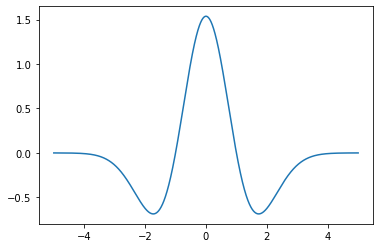

In [4]:
import mexhat_numpy
import matplotlib.pyplot as plt
import graphviz
xs, ys = mexhat_numpy.loop2()
plt.plot(xs,ys)
plt.show()

## Train the model for split_type = 'greedy'

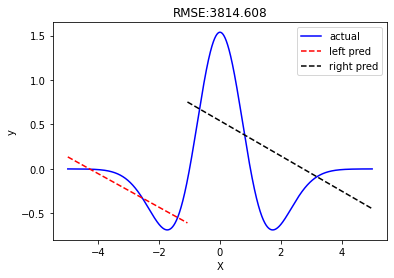

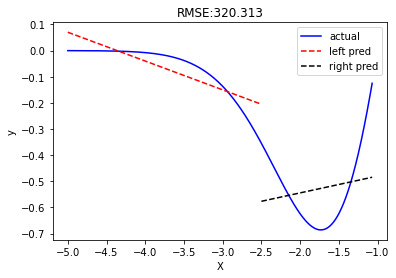

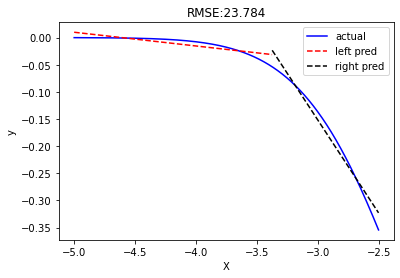

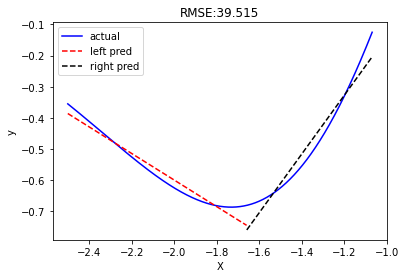

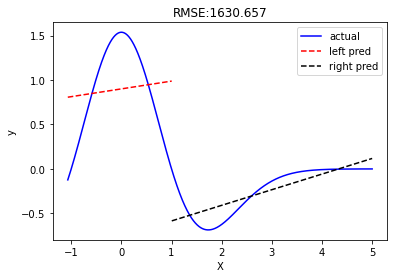

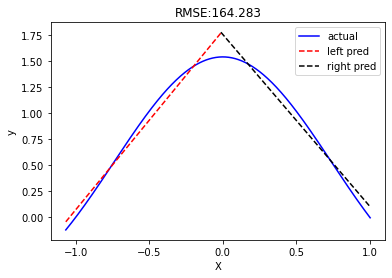

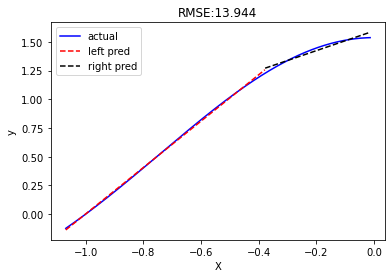

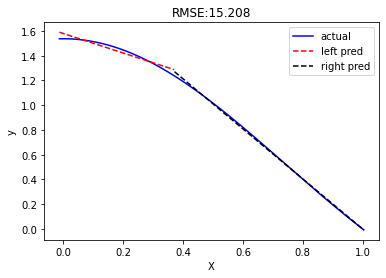

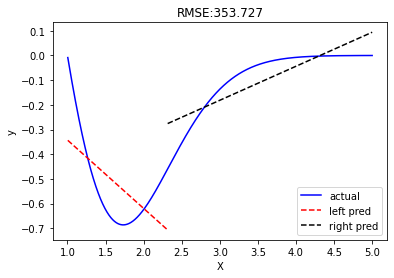

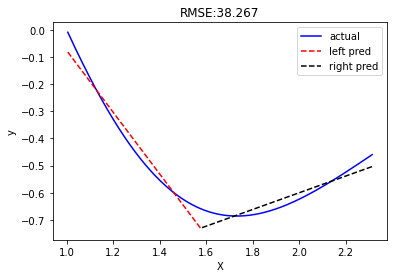

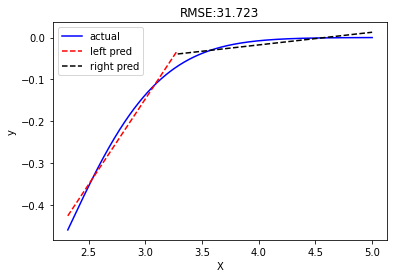

root-1
3070
rmse:5605.0
xrange:(-5.0, 5.0)
├── L-2
65E0
rmse:503.0
xrange:(-5.0, -1.07)
│   ├── L-4
CD60
rmse:124.0
xrange:(-5.0, -2.5)
│   │   ├── L-6
7EE0
rmse:11.0
xrange:(-5.0, -3.37)
│   │   └── R-7
7DC0
rmse:12.0
xrange:(-3.37, -2.5)
│   └── R-5
8DF0
rmse:196.0
xrange:(-2.5, -1.07)
│       ├── L-8
7D90
rmse:18.0
xrange:(-2.5, -1.66)
│       └── R-9
2DC0
rmse:21.0
xrange:(-1.66, -1.07)
└── R-3
7E80
rmse:3311.0
xrange:(-1.07, 5.0)
    ├── L-10
35E0
rmse:1056.0
xrange:(-1.07, 1.0)
    │   ├── L-12
45E0
rmse:80.0
xrange:(-1.07, -0.01)
    │   │   ├── L-14
F670
rmse:6.0
xrange:(-1.07, -0.38)
    │   │   └── R-15
2AC0
rmse:7.0
xrange:(-0.38, -0.01)
    │   └── R-13
5790
rmse:84.0
xrange:(-0.01, 1.0)
    │       ├── L-16
14C0
rmse:9.0
xrange:(-0.01, 0.37)
    │       └── R-17
EA90
rmse:6.0
xrange:(0.37, 1.0)
    └── R-11
9040
rmse:575.0
xrange:(1.0, 5.0)
        ├── L-18
B9D0
rmse:179.0
xrange:(1.0, 2.31)
        │   ├── L-20
B9A0
rmse:20.0
xrange:(1.0, 1.58)
        │   └── R-21
8D00
r

In [5]:
lle = LLE(rmse_threshold=50, verbose=1, split_type='greedy')
lle.fit(X=xs.reshape(-1,1), y=ys.reshape(-1,1))

## Plot the tree

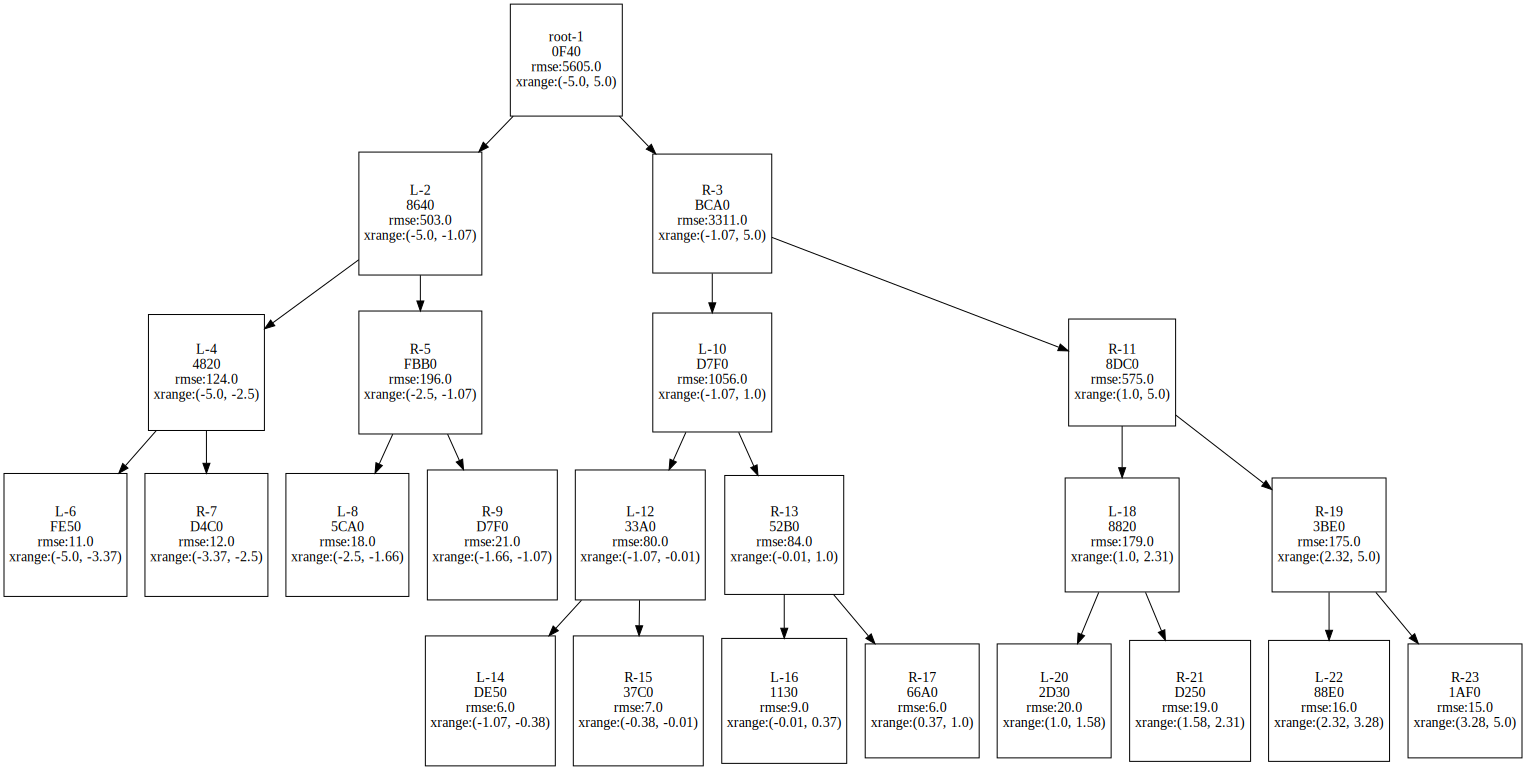

In [7]:
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## Check which models were finalized

In [8]:
lle.final_models

{(-5.0, -3.37): LinearRegression(),
 (-3.37, -2.5): LinearRegression(),
 (-2.5, -1.66): LinearRegression(),
 (-1.66, -1.07): LinearRegression(),
 (-1.07, -0.38): LinearRegression(),
 (-0.38, -0.01): LinearRegression(),
 (-0.01, 0.37): LinearRegression(),
 (0.37, 1.0): LinearRegression(),
 (1.0, 1.58): LinearRegression(),
 (1.58, 2.31): LinearRegression(),
 (2.32, 3.28): LinearRegression(),
 (3.28, 5.0): LinearRegression(),
 (-0.01, 1.0): LinearRegression(),
 (-2.5, -1.07): LinearRegression()}

## Perform a prediction

In [9]:
x = -0.6
lle.predict(x)

array([[0.80960653]])

## Check how accurate the prediction is

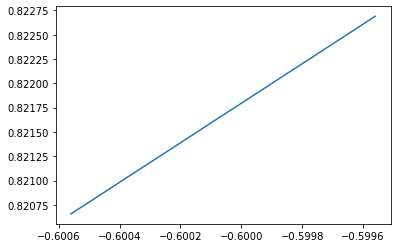

In [10]:
epsilon = 0.001
x_sub = xs[(x-epsilon<xs)&(xs<x+epsilon)]
y_sub = ys[(x-epsilon<xs)&(xs<x+epsilon)]
plt.plot(x_sub, y_sub)
plt.show()

**Observation:** For the value x=-0.6 we got a very accurate prediction of 0.81

## See how many linear models can we obtain by changing thresholds
<font color='red'>Warning!! Long running code</font>

In [10]:
thresholds = np.arange(5000, 0, -100)
from tqdm import tqdm
number_of_models = []
for threshold in tqdm(thresholds):
    lle = LLE(rmse_threshold=threshold, verbose=0)
    lle.fit(X=xs.reshape(-1,1), y=ys.reshape(-1,1))
    number_of_models.append(len(lle.final_models))

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [11:48<00:00, 14.17s/it]


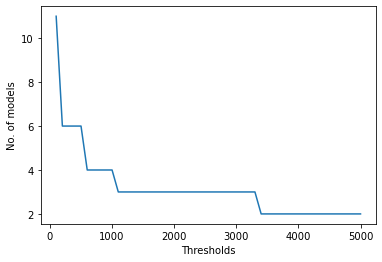

In [11]:
plt.plot(thresholds, number_of_models)
plt.xlabel('Thresholds')
plt.ylabel('No. of models')
plt.show()

## (Optional) Let's see how much of Mexican Hat could be reconstructed by our model
Also we will see what is the overall model accuracy

### Retrain the model with RMSE threshold = 10

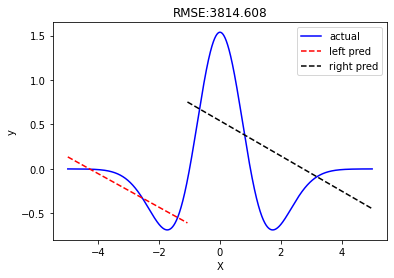

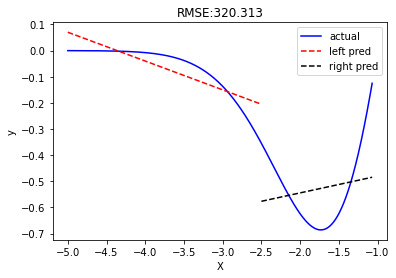

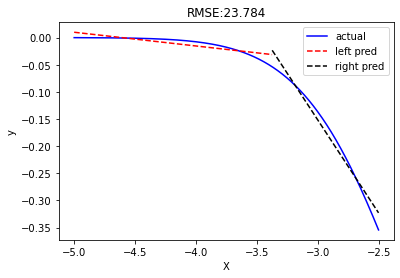

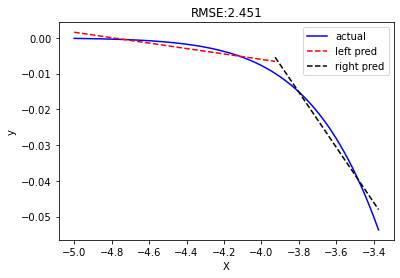

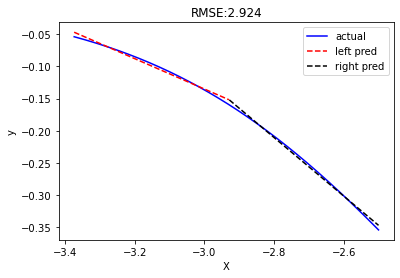

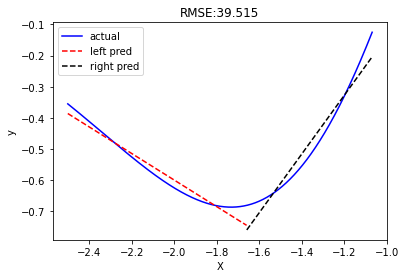

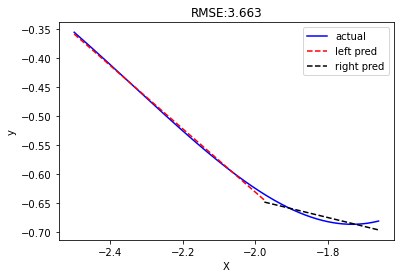

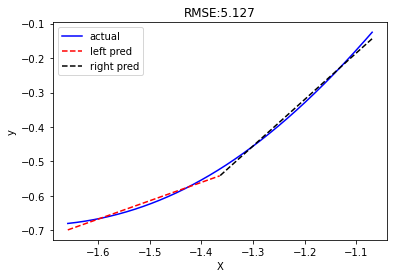

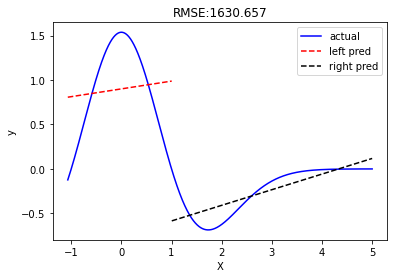

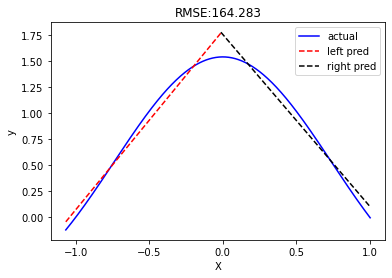

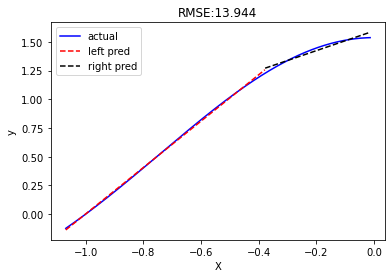

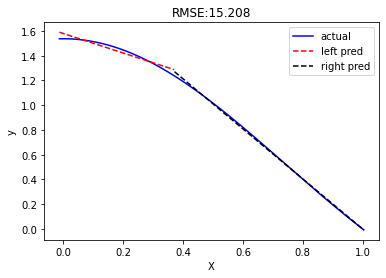

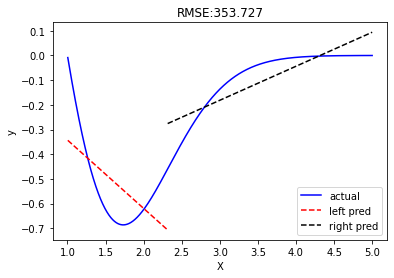

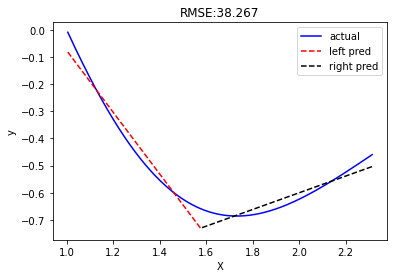

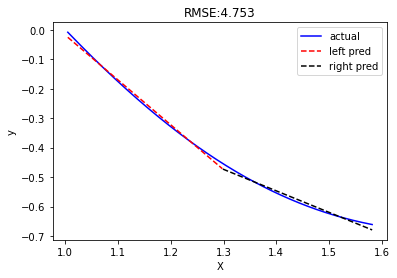

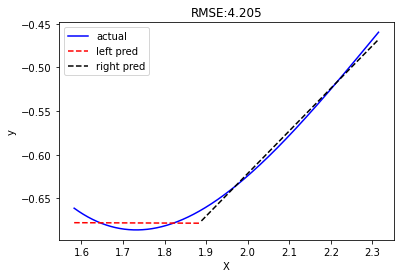

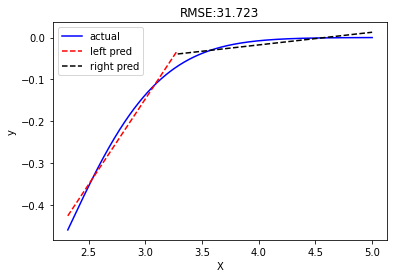

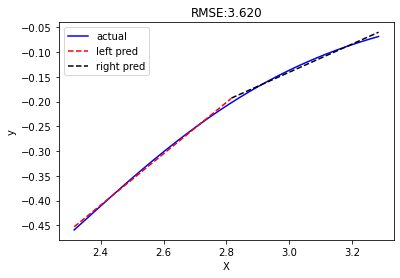

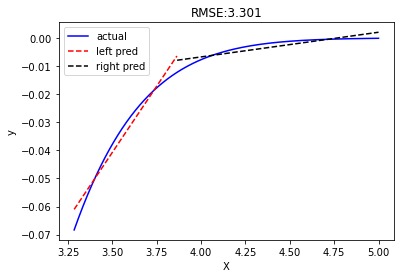

root-1
2A60
rmse:5605.0
xrange:(-5.0, 5.0)
├── L-2
7730
rmse:503.0
xrange:(-5.0, -1.07)
│   ├── L-4
8730
rmse:124.0
xrange:(-5.0, -2.5)
│   │   ├── L-6
2220
rmse:11.0
xrange:(-5.0, -3.37)
│   │   │   ├── L-8
5610
rmse:1.0
xrange:(-5.0, -3.93)
│   │   │   └── R-9
D070
rmse:1.0
xrange:(-3.93, -3.37)
│   │   └── R-7
13D0
rmse:12.0
xrange:(-3.37, -2.5)
│   │       ├── L-10
A8B0
rmse:1.0
xrange:(-3.37, -2.93)
│   │       └── R-11
F700
rmse:1.0
xrange:(-2.93, -2.5)
│   └── R-5
A6A0
rmse:196.0
xrange:(-2.5, -1.07)
│       ├── L-12
FB50
rmse:18.0
xrange:(-2.5, -1.66)
│       │   ├── L-14
9C10
rmse:2.0
xrange:(-2.5, -1.98)
│       │   └── R-15
D880
rmse:2.0
xrange:(-1.97, -1.66)
│       └── R-13
4EB0
rmse:21.0
xrange:(-1.66, -1.07)
│           ├── L-16
88B0
rmse:3.0
xrange:(-1.66, -1.36)
│           └── R-17
94F0
rmse:3.0
xrange:(-1.36, -1.07)
└── R-3
A3D0
rmse:3311.0
xrange:(-1.07, 5.0)
    ├── L-18
08B0
rmse:1056.0
xrange:(-1.07, 1.0)
    │   ├── L-20
A970
rmse:80.0
xrange:(-1.07, -0.01)
    

In [11]:
lle = LLE(rmse_threshold=10, verbose=1, split_type='greedy')
lle.fit(X=xs.reshape(-1,1), y=ys.reshape(-1,1))

### See the final model and individual domains

In [12]:
lle.final_models

{(-5.0, -3.93): LinearRegression(),
 (-3.93, -3.37): LinearRegression(),
 (-3.37, -2.93): LinearRegression(),
 (-2.93, -2.5): LinearRegression(),
 (-2.5, -1.98): LinearRegression(),
 (-1.97, -1.66): LinearRegression(),
 (-1.66, -1.36): LinearRegression(),
 (-1.36, -1.07): LinearRegression(),
 (-3.37, -2.5): LinearRegression(),
 (-1.07, -0.38): LinearRegression(),
 (-0.38, -0.01): LinearRegression(),
 (-0.01, 0.37): LinearRegression(),
 (0.37, 1.0): LinearRegression(),
 (1.0, 1.3): LinearRegression(),
 (1.3, 1.58): LinearRegression(),
 (1.58, 1.89): LinearRegression(),
 (1.89, 2.31): LinearRegression(),
 (2.32, 2.81): LinearRegression(),
 (2.82, 3.28): LinearRegression(),
 (3.28, 3.86): LinearRegression(),
 (3.86, 5.0): LinearRegression(),
 (1.58, 2.31): LinearRegression(),
 (-0.01, 1.0): LinearRegression(),
 (-2.5, -1.07): LinearRegression()}

### Perform series of predictions
For x in mexican hat

In [13]:
from tqdm import tqdm
y_pred = []
y_true = ys
for x in tqdm(xs):
    try:
        y_hat = lle.predict(x)[0][0]
    except UnboundLocalError as e:
        # it may so happen due to discretization of x_ranges
        ## some values not covered (very narrow domain)
        ## for those X's extrapolate previous y_hat
        print('Model not found for: {} interpolating y: {}'.format(x, y_hat))
    y_pred.append(y_hat)

100%|███████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16038.96it/s]

Model not found for: 2.310731073107311 interpolating y: -0.5051973226671023
Model not found for: 2.3117311731173116 interpolating y: -0.5051973226671023
Model not found for: 2.312731273127313 interpolating y: -0.5051973226671023
Model not found for: 2.3137313731373137 interpolating y: -0.5051973226671023
Model not found for: 2.314731473147315 interpolating y: -0.5051973226671023
Model not found for: 2.315731573157316 interpolating y: -0.5051973226671023
Model not found for: 2.3167316731673164 interpolating y: -0.5051973226671023
Model not found for: 2.317731773177318 interpolating y: -0.5051973226671023
Model not found for: 2.3187318731873185 interpolating y: -0.5051973226671023
Model not found for: 2.31973197319732 interpolating y: -0.5051973226671023
Model not found for: 2.8107810781078104 interpolating y: -0.19653707734956227
Model not found for: 2.811781178117812 interpolating y: -0.19653707734956227
Model not found for: 2.8127812781278125 interpolating y: -0.19653707734956227
Mode

### Plot the two curves

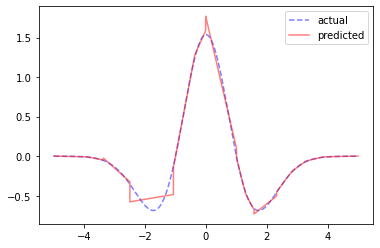

In [14]:
plt.plot(xs,ys,'--b',alpha=0.5,label='actual')
plt.plot(xs,y_pred,'-r',alpha=0.5, label='predicted')
plt.legend()
plt.show()

### Get the overall RMSE and pseudo R<sup>2</sup>

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_true=ys, y_pred=y_pred,squared=False)
r2 = r2_score(y_true=ys,y_pred=y_pred)
print('Overall RMSE: {}\nOverall pseudo R2: {}'.format(rmse,r2))

Overall RMSE: 0.05863536966851129
Overall pseudo R2: 0.9890550723626799


## (Optional) Let's see how much of Mexican Hat could be reconstructed by our model with split_type as 'binary'
Our algo also supports binary splitting. The default is greedy split where we split by a partition giving the best RMSE. In case of binary split, the splitting is always done by bisecting the x_range. We will see:
1. The algorithm is much faster.
2. But less accurate

### Retrain the model with RMSE threshold = 10

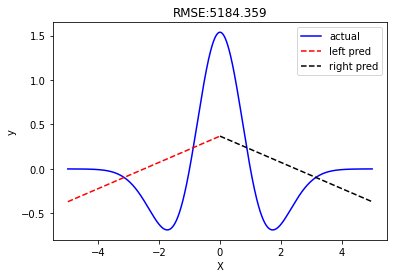

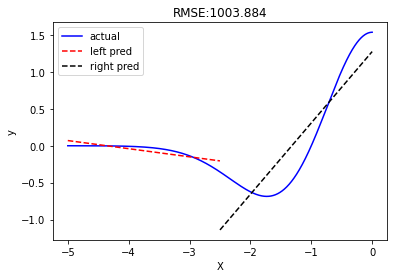

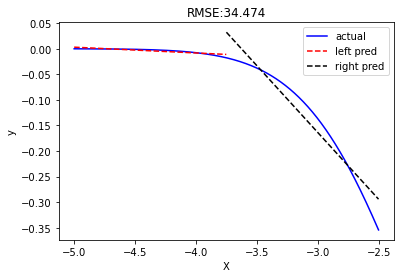

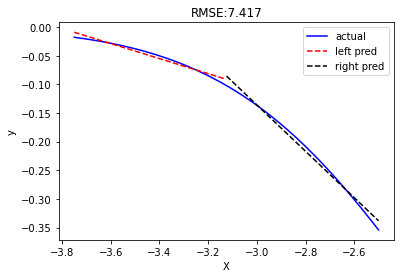

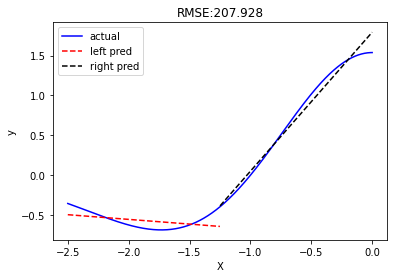

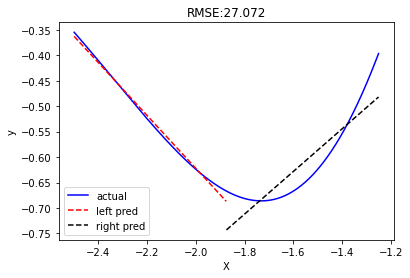

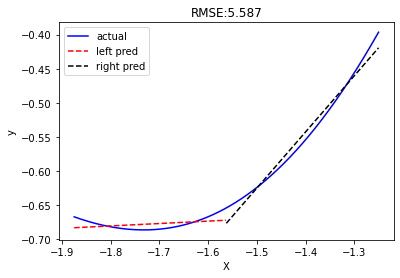

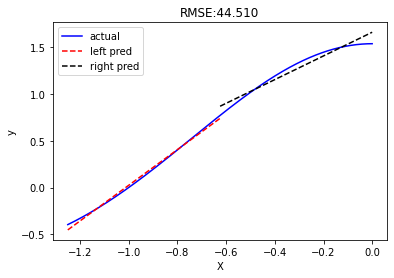

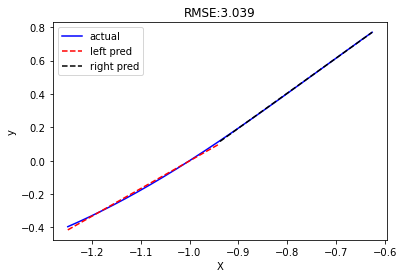

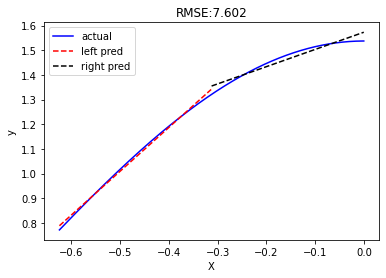

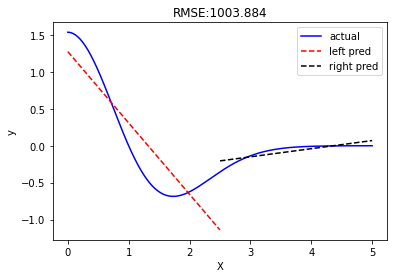

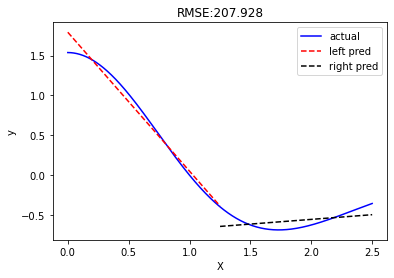

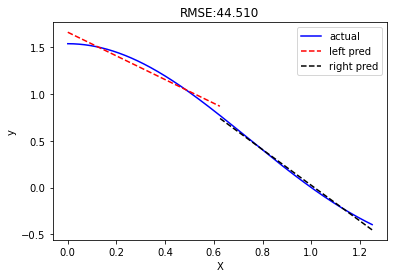

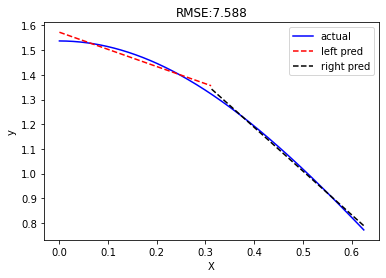

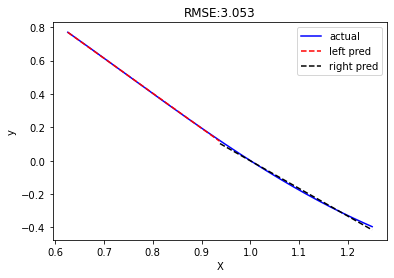

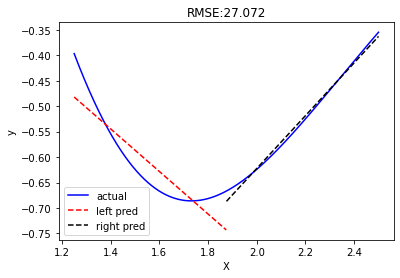

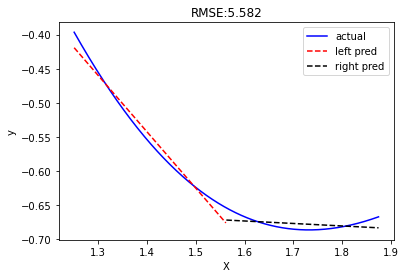

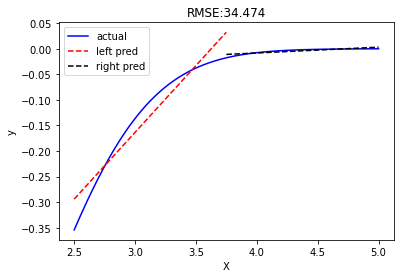

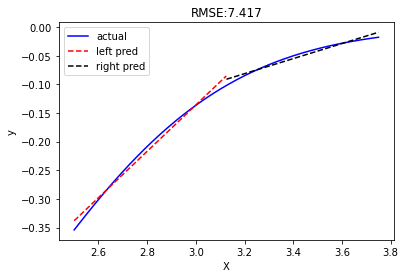

root-1
E910
rmse:5605.0
xrange:(-5.0, 5.0)
├── L-2
A070
rmse:2592.0
xrange:(-5.0, -0.0)
│   ├── L-4
6790
rmse:124.0
xrange:(-5.0, -2.5)
│   │   ├── L-6
6C40
rmse:3.0
xrange:(-5.0, -3.75)
│   │   └── R-7
6EB0
rmse:32.0
xrange:(-3.75, -2.5)
│   │       ├── L-8
2430
rmse:3.0
xrange:(-3.75, -3.13)
│   │       └── R-9
AD30
rmse:5.0
xrange:(-3.12, -2.5)
│   └── R-5
7370
rmse:879.0
xrange:(-2.5, -0.0)
│       ├── L-10
5610
rmse:112.0
xrange:(-2.5, -1.25)
│       │   ├── L-12
B550
rmse:4.0
xrange:(-2.5, -1.88)
│       │   └── R-13
38B0
rmse:23.0
xrange:(-1.87, -1.25)
│       │       ├── L-14
AA30
rmse:2.0
xrange:(-1.87, -1.56)
│       │       └── R-15
AC70
rmse:3.0
xrange:(-1.56, -1.25)
│       └── R-11
40A0
rmse:96.0
xrange:(-1.25, -0.0)
│           ├── L-16
88B0
rmse:13.0
xrange:(-1.25, -0.63)
│           │   ├── L-18
2B20
rmse:3.0
xrange:(-1.25, -0.94)
│           │   └── R-19
D700
rmse:0.0
xrange:(-0.94, -0.63)
│           └── R-17
17F0
rmse:31.0
xrange:(-0.62, -0.0)
│               ├── L-

In [16]:
lle = LLE(rmse_threshold=10, verbose=1, split_type='binary')
lle.fit(X=xs.reshape(-1,1), y=ys.reshape(-1,1))

### Plot the tree

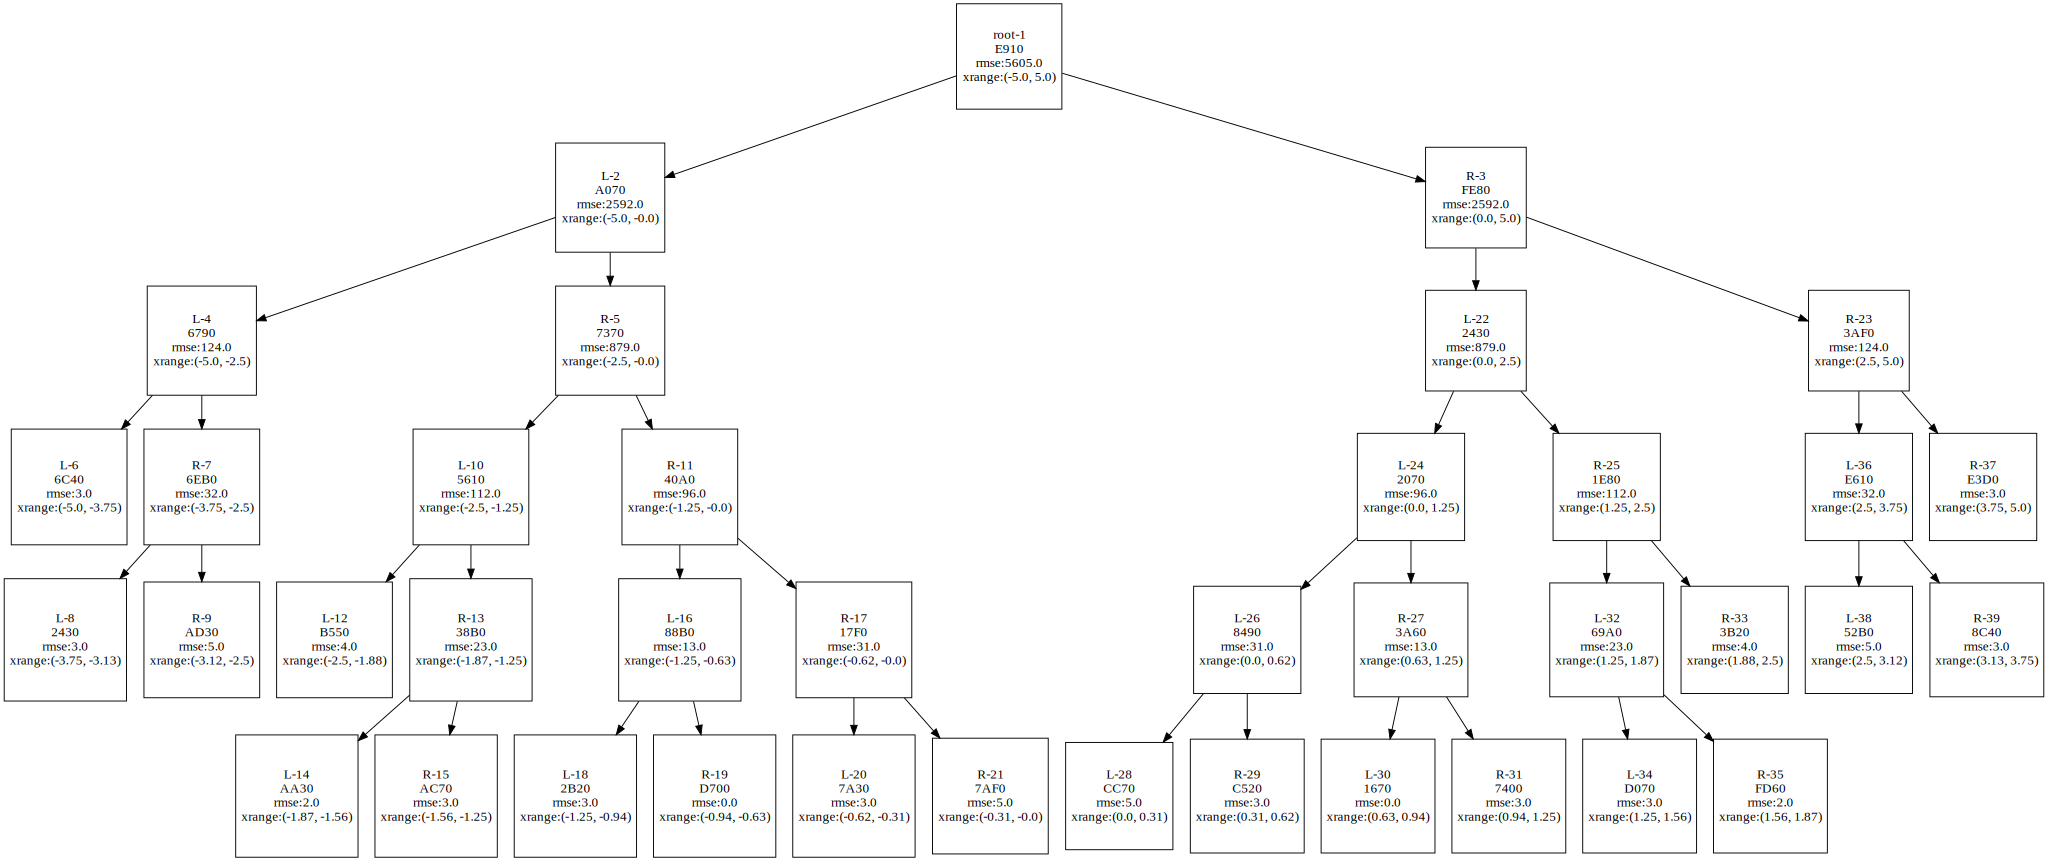

In [17]:
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### See the final model and the X value ranges

In [19]:
lle.final_models

{(-5.0, -3.75): LinearRegression(),
 (-3.75, -3.13): LinearRegression(),
 (-3.12, -2.5): LinearRegression(),
 (-2.5, -1.88): LinearRegression(),
 (-1.87, -1.56): LinearRegression(),
 (-1.56, -1.25): LinearRegression(),
 (-1.25, -0.94): LinearRegression(),
 (-0.94, -0.63): LinearRegression(),
 (-0.62, -0.31): LinearRegression(),
 (-0.31, -0.0): LinearRegression(),
 (-1.87, -1.25): LinearRegression(),
 (-3.75, -2.5): LinearRegression(),
 (0.0, 0.31): LinearRegression(),
 (0.31, 0.62): LinearRegression(),
 (0.63, 0.94): LinearRegression(),
 (0.94, 1.25): LinearRegression(),
 (1.25, 1.56): LinearRegression(),
 (1.56, 1.87): LinearRegression(),
 (1.88, 2.5): LinearRegression(),
 (0.63, 1.25): LinearRegression(),
 (2.5, 3.12): LinearRegression(),
 (3.13, 3.75): LinearRegression(),
 (3.75, 5.0): LinearRegression(),
 (1.25, 2.5): LinearRegression(),
 (-2.5, -0.0): LinearRegression()}

### Perform series of predictions
For x in mexican hat

In [20]:
y_pred = []
y_true = ys
for x in tqdm(xs):
    try:
        y_hat = lle.predict(x)[0][0]
    except UnboundLocalError as e:
        # it may so happen due to discretization of x_ranges
        ## some values not covered (very few)
        ## for those X's extrapolate previous y_hat
        print('Model not found for: {} interpolating y: {}'.format(x, y_hat))
    y_pred.append(y_hat)

 76%|██████████████████████████████████████████████████████▍                 | 7558/10000 [00:00<00:00, 12315.48it/s]

Model not found for: 0.6205620562056202 interpolating y: 0.7974254907946718
Model not found for: 0.6215621562156217 interpolating y: 0.7974254907946718
Model not found for: 0.6225622562256223 interpolating y: 0.7974254907946718
Model not found for: 0.6235623562356238 interpolating y: 0.7974254907946718
Model not found for: 0.6245624562456245 interpolating y: 0.7974254907946718
Model not found for: 0.625562556255626 interpolating y: 0.7974254907946718
Model not found for: 0.6265626562656266 interpolating y: 0.7974254907946718
Model not found for: 0.6275627562756272 interpolating y: 0.7974254907946718
Model not found for: 0.6285628562856287 interpolating y: 0.7974254907946718
Model not found for: 0.6295629562956293 interpolating y: 0.7974254907946718
Model not found for: 3.12081208120812 interpolating y: -0.08746739515381252
Model not found for: 3.1218121812181217 interpolating y: -0.08746739515381252
Model not found for: 3.122812281228123 interpolating y: -0.08746739515381252
Model not 

100%|███████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 13860.82it/s]


### Plot the two curves

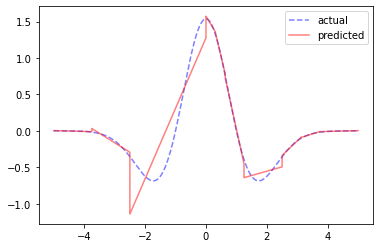

In [21]:
plt.plot(xs,ys,'--b',alpha=0.5,label='actual')
plt.plot(xs,y_pred,'-r',alpha=0.5, label='predicted')
plt.legend()
plt.show()

### Get the overall RMSE and pseudo R<sup>2</sup>

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_true=ys, y_pred=y_pred,squared=False)
r2 = r2_score(y_true=ys,y_pred=y_pred)
print('Overall RMSE: {}\nOverall pseudo R2: {}'.format(rmse,r2))

Overall RMSE: 0.17907286364096786
Overall pseudo R2: 0.8979170723170712


## (Optional) Enough! Does our model work on the Happy path scenario?
Happy path is a dataset which is already linear in nature. Expectation is we should have only **one** model in the final

### Simulate such data

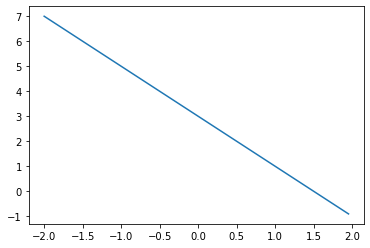

In [23]:
x_list = np.arange(-2,2,0.05)
y_list = -2*x_list + 3
plt.plot(x_list, y_list)
plt.show()

### Retrain the model with RMSE threshold = 50

In [24]:
lle = LLE(rmse_threshold=10, verbose=1, split_type='greedy')
lle.fit(X=x_list.reshape(-1,1), y=y_list.reshape(-1,1))

root-1
D2B0
rmse:0.0
xrange:(-2.0, 1.95)



### See the final model and the X value ranges

In [25]:
lle.final_models

{(-2.0, 1.95): LinearRegression()}

**Observation:** Final model is only one. Niiice!

### Perform series of predictions
For x in mexican hat

In [26]:
y_pred = []
y_true = y_list
for x in tqdm(x_list):
    try:
        y_hat = lle.predict(x)[0][0]
    except UnboundLocalError as e:
        # it may so happen due to discretization of x_ranges
        ## some values not covered (very few)
        ## for those X's extrapolate previous y_hat
        print('Model not found for: {} interpolating y: {}'.format(x, y_hat))
    y_pred.append(y_hat)

100%|█████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 16028.68it/s]

Model not found for: 1.9500000000000037 interpolating y: -0.8000000000000065


### Plot the two curves

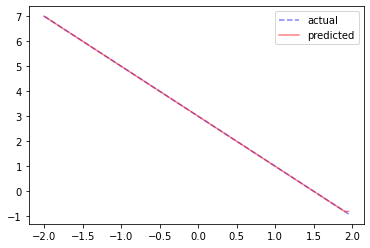

In [27]:
plt.plot(x_list,y_list,'--b',alpha=0.5,label='actual')
plt.plot(x_list,y_pred,'-r',alpha=0.5, label='predicted')
plt.legend()
plt.show()

### Get the overall RMSE and pseudo R<sup>2</sup>

In [28]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_true=y_list, y_pred=y_pred,squared=False)
r2 = r2_score(y_true=y_list,y_pred=y_pred)
print('Overall RMSE: {}\nOverall pseudo R2: {}'.format(rmse,r2))

Overall RMSE: 0.011180339887499058
Overall pseudo R2: 0.9999765588373183


## (Optional) How is noise sensitivity in happy path scenarios?
Happy path is a dataset which is already linear in nature. 
<br>Here we will introduce random gaussian noise to y
<br>The question we are asking **Is our model robust to random noises?**

### Simulate such data

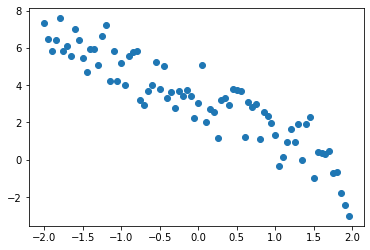

In [29]:
x_list = np.arange(-2,2,0.05)
y_list = -2*x_list + 3 + np.random.randn(len(x_list))
plt.scatter(x_list, y_list)
plt.show()

### The Greedy Split Algorithm

#### Retrain the model with RMSE threshold = 10

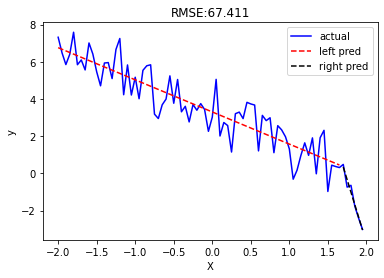

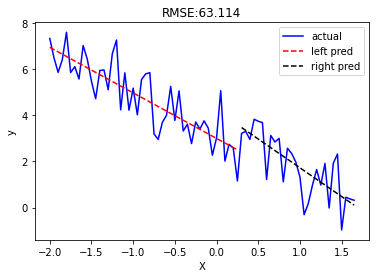

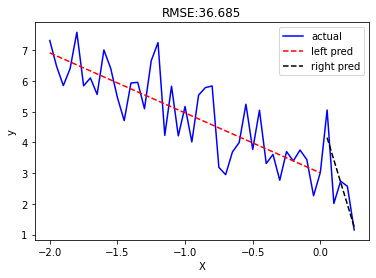

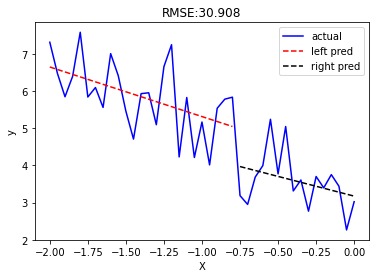

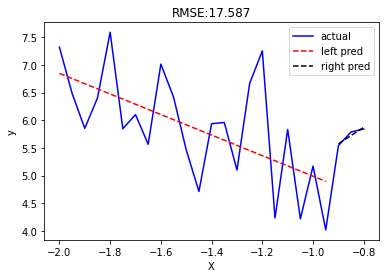

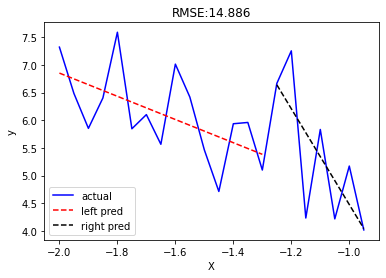

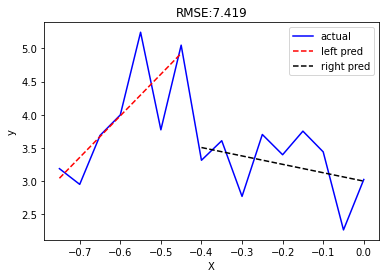

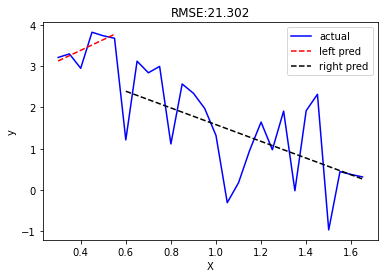

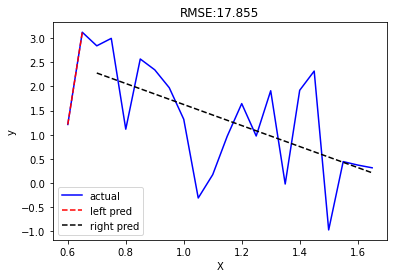

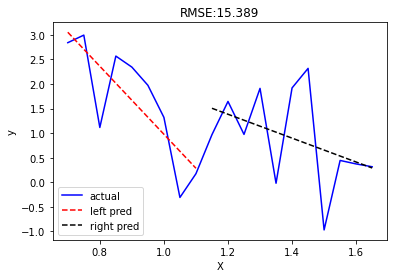

root-1
F880
rmse:77.0
xrange:(-2.0, 1.95)
├── L-2
8970
rmse:66.0
xrange:(-2.0, 1.65)
│   ├── L-4
4310
rmse:39.0
xrange:(-2.0, 0.25)
│   │   ├── L-6
3B50
rmse:33.0
xrange:(-2.0, 0.0)
│   │   │   ├── L-8
BF10
rmse:20.0
xrange:(-2.0, -0.8)
│   │   │   │   ├── L-10
5E50
rmse:17.0
xrange:(-2.0, -0.95)
│   │   │   │   │   ├── L-12
D2E0
rmse:9.0
xrange:(-2.0, -1.3)
│   │   │   │   │   └── R-13
1880
rmse:6.0
xrange:(-1.25, -0.95)
│   │   │   │   └── R-11
8F70
rmse:0.0
xrange:(-0.9, -0.8)
│   │   │   └── R-9
B220
rmse:11.0
xrange:(-0.75, 0.0)
│   │   │       ├── L-14
8DF0
rmse:4.0
xrange:(-0.75, -0.45)
│   │   │       └── R-15
E280
rmse:4.0
xrange:(-0.4, 0.0)
│   │   └── R-7
BC40
rmse:4.0
xrange:(0.05, 0.25)
│   └── R-5
0BB0
rmse:24.0
xrange:(0.3, 1.65)
│       ├── L-16
3DC0
rmse:1.0
xrange:(0.3, 0.55)
│       └── R-17
1C70
rmse:20.0
xrange:(0.6, 1.65)
│           ├── L-18
25E0
rmse:0.0
xrange:(0.6, 0.65)
│           └── R-19
C7C0
rmse:18.0
xrange:(0.7, 1.65)
│               ├── L-20
C970
rmse:

In [30]:
lle = LLE(rmse_threshold=10, verbose=1, split_type='greedy')
lle.fit(X=x_list.reshape(-1,1), y=y_list.reshape(-1,1))

#### Perform series of predictions
For x in custom dataset

In [31]:
y_pred = []
y_true = y_list
for x in tqdm(x_list):
    try:
        y_hat = lle.predict(x)[0][0]
    except UnboundLocalError as e:
        # it may so happen due to discretization of x_ranges
        ## some values not covered (very few)
        ## for those X's extrapolate previous y_hat
        print('Model not found for: {} interpolating y: {}'.format(x, y_hat))
    y_pred.append(y_hat)

100%|██████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 8021.43it/s]

Model not found for: -1.2999999999999994 interpolating y: 5.488094476011248
Model not found for: -0.9499999999999991 interpolating y: 4.474684371159821
Model not found for: -0.7999999999999989 interpolating y: 5.723375408144985
Model not found for: 1.7763568394002505e-15 interpolating y: 3.2279426829540157
Model not found for: 0.2500000000000018 interpolating y: 1.981483702430276
Model not found for: 1.650000000000003 interpolating y: 0.22703584908002128
Model not found for: 1.9500000000000037 interpolating y: -2.3605976070555137


#### Plot the two curves

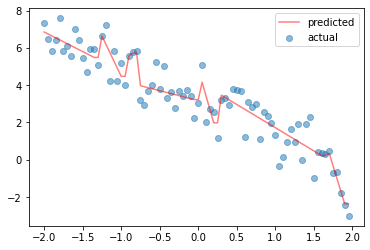

In [32]:
plt.scatter(x_list,y_list,alpha=0.5,label='actual')
plt.plot(x_list,y_pred,'-r',alpha=0.5, label='predicted')
plt.legend()
plt.show()

#### Get the overall RMSE and pseudo R<sup>2</sup>

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_true=y_list, y_pred=y_pred,squared=False)
r2 = r2_score(y_true=y_list,y_pred=y_pred)
print('Overall RMSE: {}\nOverall pseudo R2: {}'.format(rmse,r2))

Overall RMSE: 0.736748192518261
Overall pseudo R2: 0.9046536457076775


**Observation:** As expected our greedy algorithm is not much robust to noises. Let's see how the binary one does on random noise

### Binary Split Algorithm

#### Retrain the model with RMSE threshold = 50

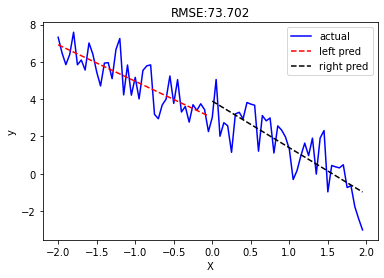

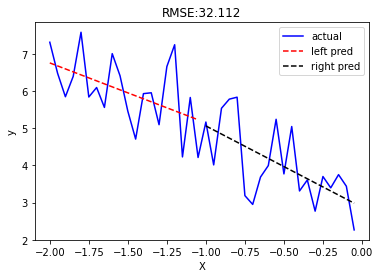

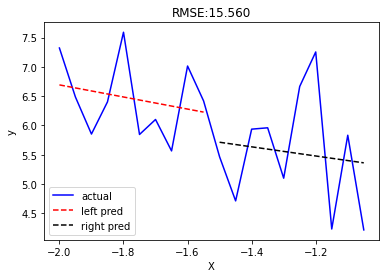

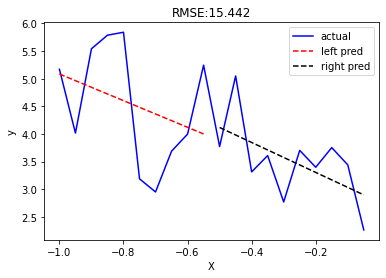

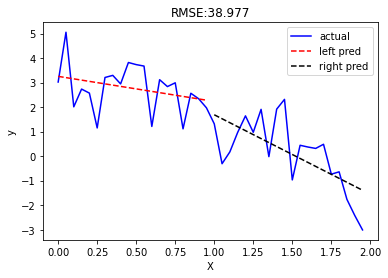

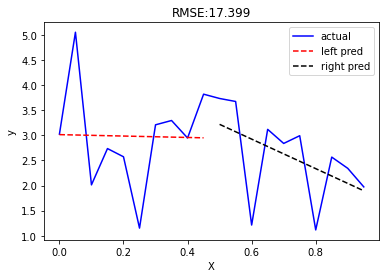

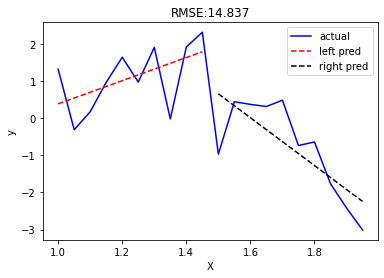

root-1
E940
rmse:77.0
xrange:(-2.0, 1.95)
├── L-2
B760
rmse:32.0
xrange:(-2.0, -0.05)
│   ├── L-4
7760
rmse:16.0
xrange:(-2.0, -1.05)
│   │   ├── L-6
4FD0
rmse:6.0
xrange:(-2.0, -1.55)
│   │   └── R-7
0130
rmse:9.0
xrange:(-1.5, -1.05)
│   └── R-5
E790
rmse:16.0
xrange:(-1.0, -0.05)
│       ├── L-8
2220
rmse:10.0
xrange:(-1.0, -0.55)
│       └── R-9
07C0
rmse:6.0
xrange:(-0.5, -0.05)
└── R-3
5670
rmse:41.0
xrange:(0.0, 1.95)
    ├── L-10
AB50
rmse:18.0
xrange:(0.0, 0.95)
    │   ├── L-12
2E50
rmse:10.0
xrange:(0.0, 0.45)
    │   └── R-13
18B0
rmse:8.0
xrange:(0.5, 0.95)
    └── R-11
25E0
rmse:21.0
xrange:(1.0, 1.95)
        ├── L-14
E3D0
rmse:7.0
xrange:(1.0, 1.45)
        └── R-15
2700
rmse:8.0
xrange:(1.5, 1.95)



In [34]:
lle = LLE(rmse_threshold=10, verbose=1, split_type='binary')
lle.fit(X=x_list.reshape(-1,1), y=y_list.reshape(-1,1))

#### Perform series of predictions
For x in custom dataset

In [35]:
y_pred = []
y_true = y_list
for x in tqdm(x_list):
    try:
        y_hat = lle.predict(x)[0][0]
    except UnboundLocalError as e:
        # it may so happen due to discretization of x_ranges
        ## some values not covered (very few)
        ## for those X's extrapolate previous y_hat
        print('Model not found for: {} interpolating y: {}'.format(x, y_hat))
    y_pred.append(y_hat)

100%|████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<?, ?it/s]

Model not found for: -1.5499999999999996 interpolating y: 6.278847607100811
Model not found for: -1.0499999999999992 interpolating y: 5.399972545156243
Model not found for: -0.04999999999999827 interpolating y: 3.0937664836325136
Model not found for: 0.45000000000000195 interpolating y: 2.9588878791786386
Model not found for: 0.9500000000000028 interpolating y: 2.0425020573698007
Model not found for: 1.4500000000000028 interpolating y: 1.6363409943324485
Model not found for: 1.9500000000000037 interpolating y: -1.9198636604888009


### Plot the two curves

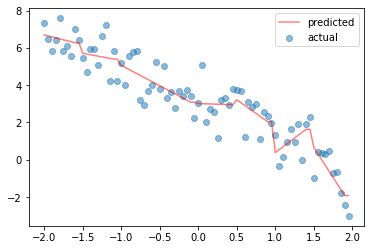

In [36]:
plt.scatter(x_list,y_list,alpha=0.5,label='actual')
plt.plot(x_list,y_pred,'-r',alpha=0.5, label='predicted')
plt.legend()
plt.show()

#### Get the overall RMSE and pseudo R<sup>2</sup>

In [38]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_true=y_list, y_pred=y_pred,squared=False)
r2 = r2_score(y_true=y_list,y_pred=y_pred)
print('Overall RMSE: {}\nOverall pseudo R2: {}'.format(rmse,r2))

Overall RMSE: 0.8133775423816142
Overall pseudo R2: 0.8837881839093716


**Observation:** Even the binary split strategy is not much robust to noises but bit better than the greedy approach

### Change in model robustness with changing RMSE threshold
Below for different threshold we will train and perform prediction and see the model's robustness to the noises

### The Greedy Split Algorithm

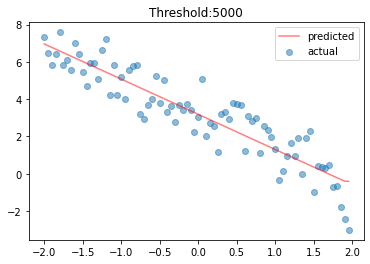

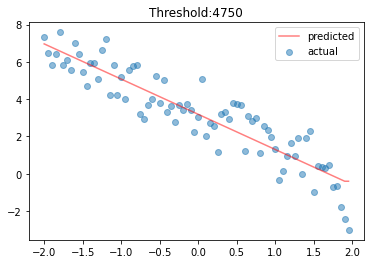

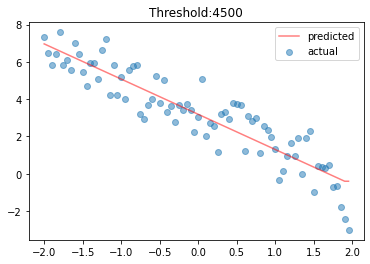

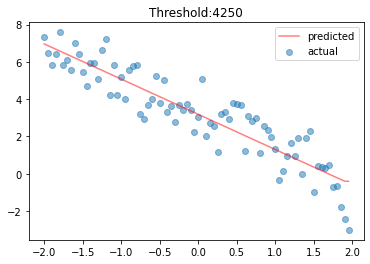

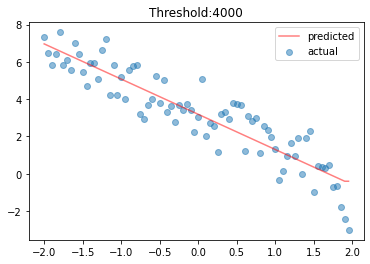

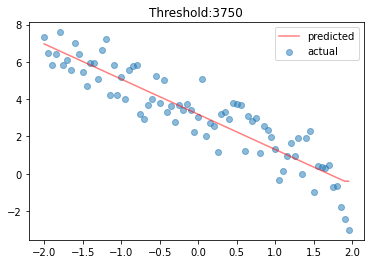

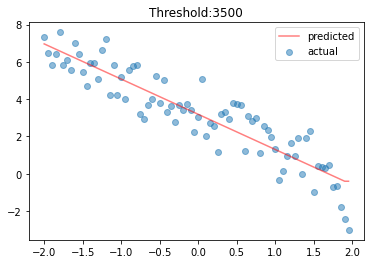

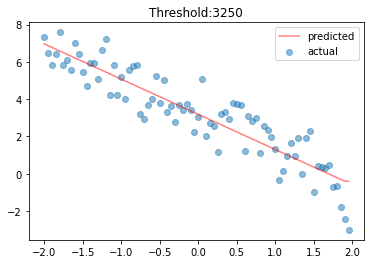

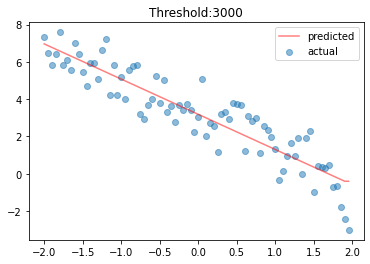

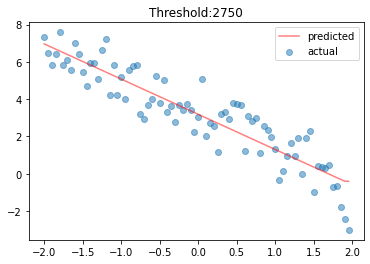

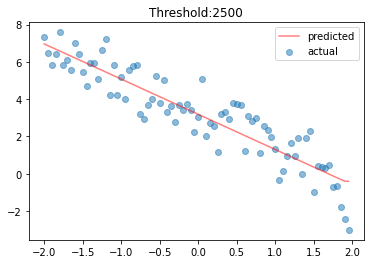

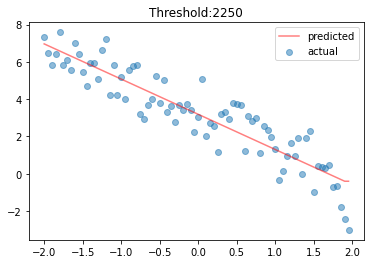

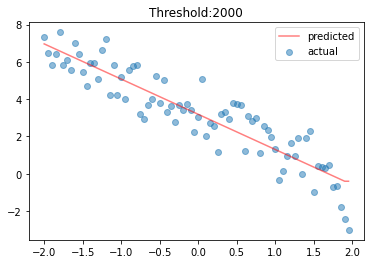

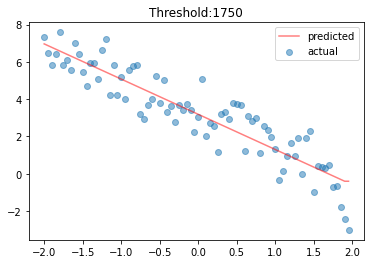

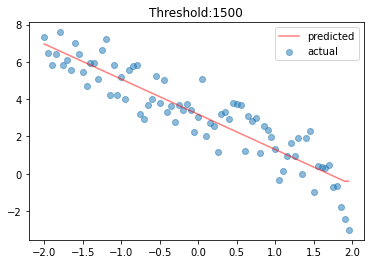

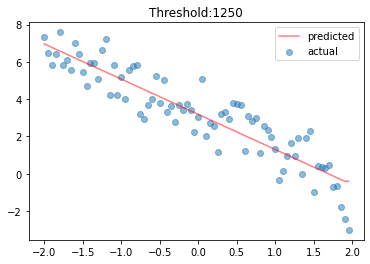

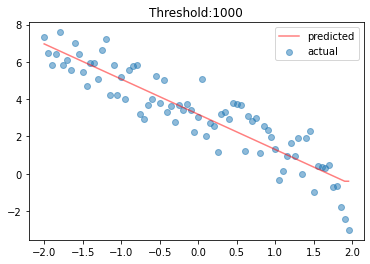

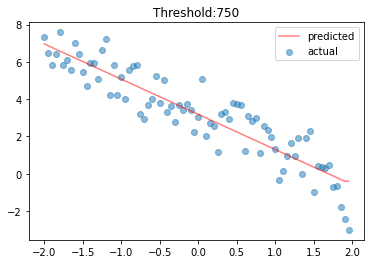

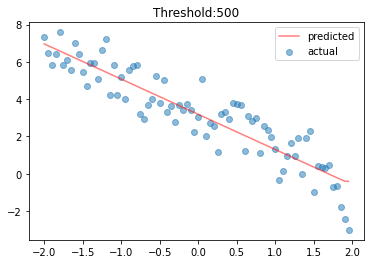

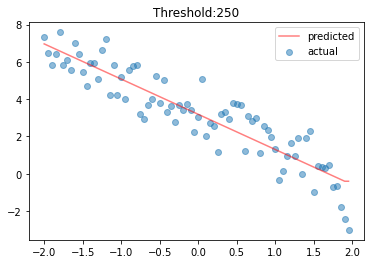

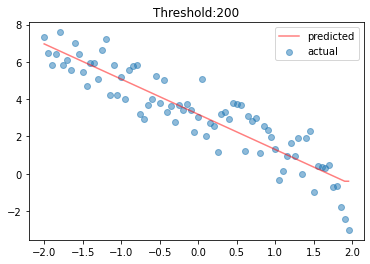

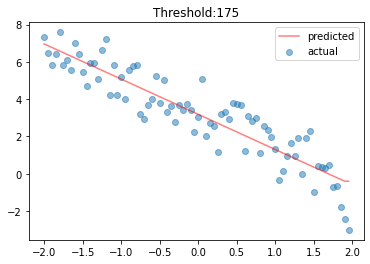

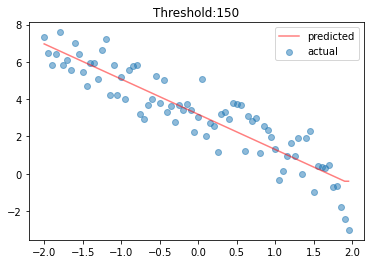

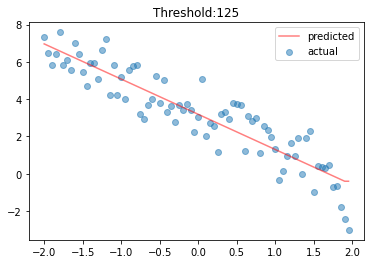

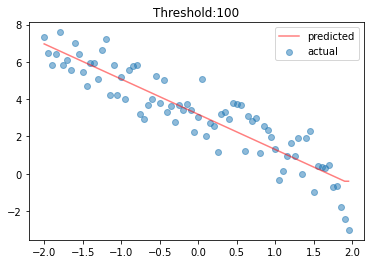

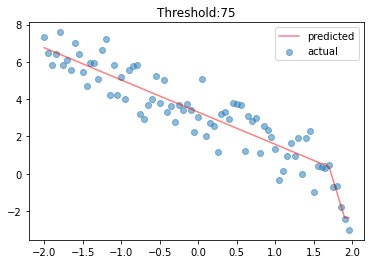

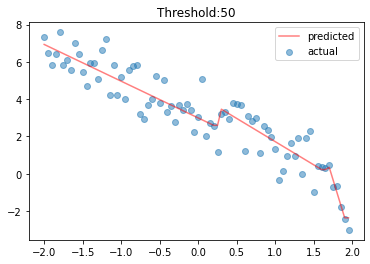

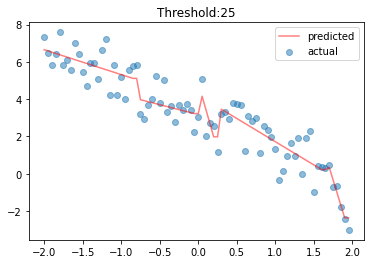

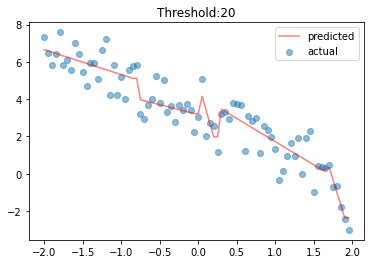

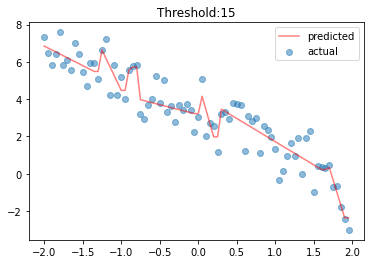

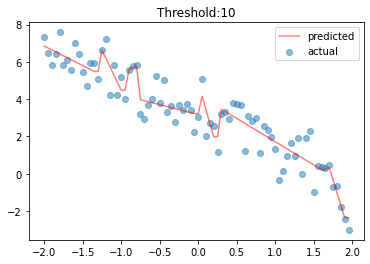

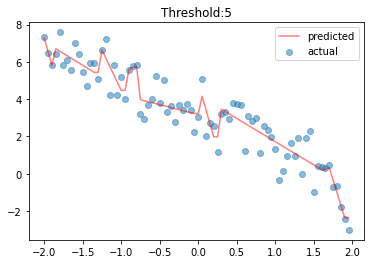

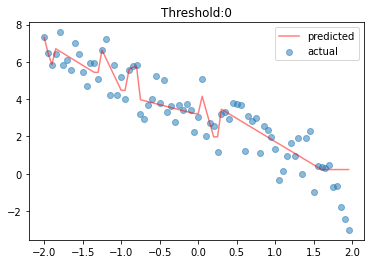

In [39]:
thresholds = list(np.arange(5000, 0, -250))
thresholds.extend(np.arange(200,0,-25))
thresholds.extend(np.arange(20,-5,-5))
for threshold in thresholds:
    lle = LLE(rmse_threshold=threshold, verbose=0, split_type='greedy')
    lle.fit(X=x_list.reshape(-1,1), y=y_list.reshape(-1,1))
    # run predictions
    y_pred = []
    y_true = y_list
    for x in x_list:
        try:
            y_hat = lle.predict(x)[0][0]
        except UnboundLocalError as e:
            # it may so happen due to discretization of x_ranges
            ## some values not covered (very few)
            ## for those X's extrapolate previous y_hat
            pass
        y_pred.append(y_hat)
    
    #### Plot the two curves
    plt.scatter(x_list,y_list,alpha=0.5,label='actual')
    plt.plot(x_list,y_pred,'-r',alpha=0.5, label='predicted')
    plt.legend()
    plt.title('Threshold:{}'.format(threshold))
    plt.show()

**Observation:** Thus we can see that with decrease in threshold value we could control the bias variance tradeoff of our algorithm to random noises.